## Approach (based on https://web.stanford.edu/~jurafsky/slp3/ - Jurafsky 2018)
1. POS tagging and entity chunking
2. For each verb in *s*, find the longest sequence of words *w* that start with a verb and satisfy syntactic and lexical constraints, merging adjacent matches
3. For each phrase *w*, find the nearest noun phrase *x* to the left which is not a relative pronoun, wh-word or existential "there". Find the nearest noun phrase *y* to the right.
4. Assign confidence *c* to the relation *r=(x,w,y)* using confidence classifier and return it.

A relation is only accepted if it meets syntactic and lexical contraints.

In [5]:
import spacy
import os
import re
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize

# for plotting the dependency tree
path_to_gs = "C:/Program Files/gs/gs9.25/bin"
os.environ['PATH'] += os.pathsep + path_to_gs


# Choose a language

In [6]:
# DE or EN
lang = 'DE'

In [9]:
if lang == 'DE':
    nlp = spacy.load('de')
    text = u'''Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London. Sie sind zum ersten Mal in England. 
            Peter und Maria gehen morgen ins Kino. Ich und mein Sohn gehen heute zum Fußball. 
            Ich gehe mit Johann in den Zoo.'''
elif lang == 'EN':
    nlp = spacy.load('en')
    text = 'United has a hub in Chicago, which is the headquarter of United Continental Holdings. \
             Tim Cook is the CEO of Apple.\
             Bill Gates is the founder of Microsoft.'
    
utterance = text

## 1. POS Tagging and entity chunking

In [10]:
sentences = sent_tokenize(utterance)
sentences

['Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London.',
 'Sie sind zum ersten Mal in England.',
 'Peter und Maria gehen morgen ins Kino.',
 'Ich und mein Sohn gehen heute zum Fußball.',
 'Ich gehe mit Johann in den Zoo.']

In [11]:
pos_tagged_sentences = []

for sentence in sentences:
    doc = nlp(sentence)
    
    pos_tagged_sentence = []
    for token in doc:
        pos_tuple = (token.text, token.pos_)
        pos_tagged_sentence.append(pos_tuple)
        
    pos_tagged_sentences.append(pos_tagged_sentence)
    
pos_tagged_sentences

[[('Meine', 'DET'),
  ('kleine', 'ADJ'),
  ('Enkelin', 'NOUN'),
  ('Lisa', 'PROPN'),
  ('und', 'CONJ'),
  ('mein', 'DET'),
  ('Enkel', 'NOUN'),
  ('Lukas', 'PROPN'),
  ('fliegen', 'VERB'),
  ('morgen', 'ADV'),
  ('nach', 'ADP'),
  ('London', 'PROPN'),
  ('.', 'PUNCT')],
 [('Sie', 'PRON'),
  ('sind', 'AUX'),
  ('zum', 'ADP'),
  ('ersten', 'ADJ'),
  ('Mal', 'NOUN'),
  ('in', 'ADP'),
  ('England', 'PROPN'),
  ('.', 'PUNCT')],
 [('Peter', 'PROPN'),
  ('und', 'CONJ'),
  ('Maria', 'PROPN'),
  ('gehen', 'VERB'),
  ('morgen', 'ADV'),
  ('ins', 'ADP'),
  ('Kino', 'NOUN'),
  ('.', 'PUNCT')],
 [('Ich', 'PRON'),
  ('und', 'CONJ'),
  ('mein', 'DET'),
  ('Sohn', 'NOUN'),
  ('gehen', 'VERB'),
  ('heute', 'ADV'),
  ('zum', 'ADP'),
  ('Fußball', 'NOUN'),
  ('.', 'PUNCT')],
 [('Ich', 'PRON'),
  ('gehe', 'VERB'),
  ('mit', 'ADP'),
  ('Johann', 'PROPN'),
  ('in', 'ADP'),
  ('den', 'DET'),
  ('Zoo', 'NOUN'),
  ('.', 'PUNCT')]]

## 2. Find the longest verb sequence

In [12]:
# for spaCy POS Tags
# V | VP | VW*P
grammar = r"""NP: {<DT>?<JJ>*<PROPN|NOUN|PRON>}
              V: {<VERB>}
              W: {<NOUN|ADJ|ADV|PROPN|DET>}
              P: {<ADP|PART|PUNCT>}
              C: {<CONJ>}
              REL: {<V><W>*<P>|<V><P>|<V>|<C>}
              """

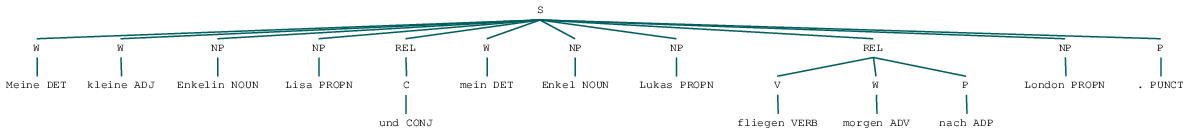

In [13]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[0])

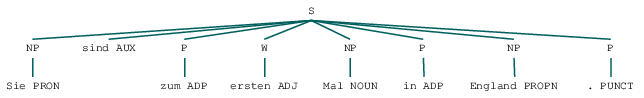

In [14]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[1])

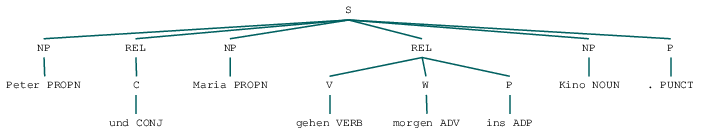

In [15]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[2])

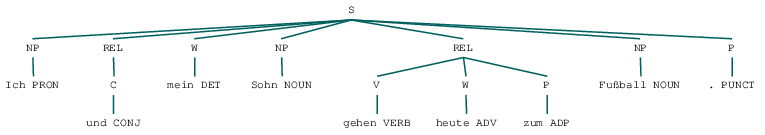

In [16]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[3])

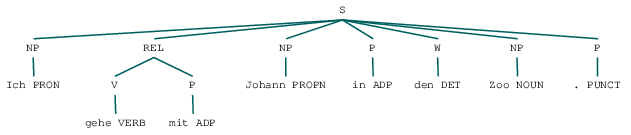

In [17]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[4])

In [18]:
cp = nltk.RegexpParser(grammar)
sentence_trees = []

for sentence in pos_tagged_sentences:
    sentence_trees.append(cp.parse(sentence))

sentence_trees

[Tree('S', [Tree('W', [('Meine', 'DET')]), Tree('W', [('kleine', 'ADJ')]), Tree('NP', [('Enkelin', 'NOUN')]), Tree('NP', [('Lisa', 'PROPN')]), Tree('REL', [Tree('C', [('und', 'CONJ')])]), Tree('W', [('mein', 'DET')]), Tree('NP', [('Enkel', 'NOUN')]), Tree('NP', [('Lukas', 'PROPN')]), Tree('REL', [Tree('V', [('fliegen', 'VERB')]), Tree('W', [('morgen', 'ADV')]), Tree('P', [('nach', 'ADP')])]), Tree('NP', [('London', 'PROPN')]), Tree('P', [('.', 'PUNCT')])]),
 Tree('S', [Tree('NP', [('Sie', 'PRON')]), ('sind', 'AUX'), Tree('P', [('zum', 'ADP')]), Tree('W', [('ersten', 'ADJ')]), Tree('NP', [('Mal', 'NOUN')]), Tree('P', [('in', 'ADP')]), Tree('NP', [('England', 'PROPN')]), Tree('P', [('.', 'PUNCT')])]),
 Tree('S', [Tree('NP', [('Peter', 'PROPN')]), Tree('REL', [Tree('C', [('und', 'CONJ')])]), Tree('NP', [('Maria', 'PROPN')]), Tree('REL', [Tree('V', [('gehen', 'VERB')]), Tree('W', [('morgen', 'ADV')]), Tree('P', [('ins', 'ADP')])]), Tree('NP', [('Kino', 'NOUN')]), Tree('P', [('.', 'PUNCT')]

### 3. Find the nearest noun phrase to REL

In [19]:
relations = []

for sent_tree in sentence_trees:
    for i, sub_tree in enumerate(sent_tree):
        if type(sub_tree) is nltk.tree.Tree and sub_tree.label() == 'REL':
            rel = sub_tree

            # find the nearest NP to the left of REL
            for j in range(i-1, -1, -1):
                if type(sent_tree[j]) is nltk.tree.Tree and sent_tree[j].label() == 'NP':
                    #print(f'left NP {j}: {tree[j]}')
                    left_noun = sent_tree[j]
                    break
            # find the nearest NP to the right of REL
            for j in range(i+1, len(sent_tree), 1):
                if type(sent_tree[j]) is nltk.tree.Tree and sent_tree[j].label() == 'NP':
                    #print(f'right NP {j}: {tree[j]}')
                    right_noun = sent_tree[j]
                    break

            relations.append([left_noun, rel, right_noun])     

relations

[[Tree('NP', [('Lisa', 'PROPN')]),
  Tree('REL', [Tree('C', [('und', 'CONJ')])]),
  Tree('NP', [('Enkel', 'NOUN')])],
 [Tree('NP', [('Lukas', 'PROPN')]),
  Tree('REL', [Tree('V', [('fliegen', 'VERB')]), Tree('W', [('morgen', 'ADV')]), Tree('P', [('nach', 'ADP')])]),
  Tree('NP', [('London', 'PROPN')])],
 [Tree('NP', [('Peter', 'PROPN')]),
  Tree('REL', [Tree('C', [('und', 'CONJ')])]),
  Tree('NP', [('Maria', 'PROPN')])],
 [Tree('NP', [('Maria', 'PROPN')]),
  Tree('REL', [Tree('V', [('gehen', 'VERB')]), Tree('W', [('morgen', 'ADV')]), Tree('P', [('ins', 'ADP')])]),
  Tree('NP', [('Kino', 'NOUN')])],
 [Tree('NP', [('Ich', 'PRON')]),
  Tree('REL', [Tree('C', [('und', 'CONJ')])]),
  Tree('NP', [('Sohn', 'NOUN')])],
 [Tree('NP', [('Sohn', 'NOUN')]),
  Tree('REL', [Tree('V', [('gehen', 'VERB')]), Tree('W', [('heute', 'ADV')]), Tree('P', [('zum', 'ADP')])]),
  Tree('NP', [('Fußball', 'NOUN')])],
 [Tree('NP', [('Ich', 'PRON')]),
  Tree('REL', [Tree('V', [('gehe', 'VERB')]), Tree('P', [('mit', 

In [21]:
relation_tuples = []

for relation in relations:
    relation_tuple = []
    for tree in relation:
        words = [w for w, t in tree.leaves()]     
        relation_tuple.append(tuple(words))

    relation_tuples.append(relation_tuple)

relation_tuples

Words ['Lisa']
Words ['und']
Words ['Enkel']
Words ['Lukas']
Words ['fliegen', 'morgen', 'nach']
Words ['London']
Words ['Peter']
Words ['und']
Words ['Maria']
Words ['Maria']
Words ['gehen', 'morgen', 'ins']
Words ['Kino']
Words ['Ich']
Words ['und']
Words ['Sohn']
Words ['Sohn']
Words ['gehen', 'heute', 'zum']
Words ['Fußball']
Words ['Ich']
Words ['gehe', 'mit']
Words ['Johann']


[[('Lisa',), ('und',), ('Enkel',)],
 [('Lukas',), ('fliegen', 'morgen', 'nach'), ('London',)],
 [('Peter',), ('und',), ('Maria',)],
 [('Maria',), ('gehen', 'morgen', 'ins'), ('Kino',)],
 [('Ich',), ('und',), ('Sohn',)],
 [('Sohn',), ('gehen', 'heute', 'zum'), ('Fußball',)],
 [('Ich',), ('gehe', 'mit'), ('Johann',)]]

## Draw relationships as network with networkx

In [83]:
import os
import networkx as nx
import matplotlib.pyplot as plt

from networkx import nx_pydot

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Source: Lisa, Target: Enkel
Source: Lukas, Target: London
Source: Peter, Target: Maria
Source: Maria, Target: Kino
Source: Ich, Target: Sohn
Source: Sohn, Target: Fußball
Source: Ich, Target: Johann


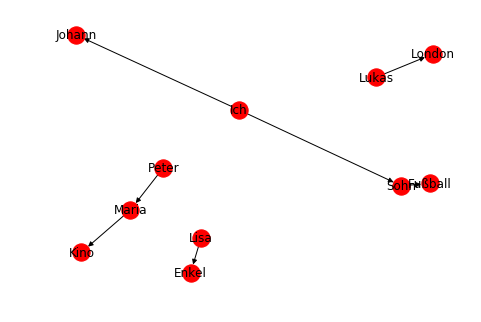

In [100]:
ng = nx.DiGraph()

for relation in relation_tuples:
    source = relation[0][0]
    target = relation[2][0]
    print(f"Source: {source}, Target: {target}")
    ng.add_edge(source, target)

#nx.spring_layout(ng)
nx.draw(ng, with_labels=True)

## 4. Assign confidence value

* compute confidence score for each relation using a logistic regression classifier

In [ ]:
TOD